<a href="https://colab.research.google.com/github/BasilKVarghese/QuoraSimilarQuestionIndentification/blob/main/Quora_Similar_questions_identification_Glove_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


import sklearn
from sklearn import preprocessing

### NLP Libraries
import string
import re
from nltk.tokenize import  word_tokenize 
import nltk
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
stpwords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
pd.options.display.max_colwidth = 500


### Importing TensorFlow Libraries

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU , Flatten, Dropout, Bidirectional, Multiply, Lambda, BatchNormalization, concatenate, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import keras.backend as K

## Importing Word2Vec Embeddings

# import gensim
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from gensim.models import KeyedVectors
# filename = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'
# w2v_dictionary = KeyedVectors.load_word2vec_format(filename, binary=True)

# if glove file is on your google drive and you are running the notebook on colab, run this code below, else ignore


## Importing Glove Embeddings
path = '/content/drive/My Drive/glove.6B.200d.txt'
## Loading Glove vectors
glove_dictionary = {}
with open(path) as file:
  for each_line in file:
      words_in_line, coeff_cients = each_line.split(maxsplit=1)
      coeff_cients = np.array(coeff_cients.split(),dtype = float)
      glove_dictionary[words_in_line] = coeff_cients


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# stpwords = {'a','about','again','ain','am',
#  'and',
#  'any',
#  'as',
#  'at',
#  'be',
#  'because',
#  'been',
#  'being',
#  'both',
#  'd',
#  'each',
#  'for',
#  'from',
#  'further',
#  'he',
#  'her',
#  'here',
#  'hers',
#  'herself',
#  'him',
#  'himself',
#  'his',
#  'how',
#  'i',
#  'if',
#  'in',
#  'into',
#  'just',
#  'll',
#  'm',
#  'ma',
#  'me',
#  'my',
#  'myself',
#  'now',
#  'o',
#  'of',
#  'off',
#  'or',
#  'other',
#  'our',
#  'ours',
#  're',
#  's',
#  'she',
#  "she's",
#  'so',
#  'such',
#  't',
#  'than',
#  'that',
#  "that'll",
#  'the',
#  'their',
#  'theirs',
#  'them',
#  'themselves',
#  'then',
#  'there',
#  'these',
#  'they',
#  'this',
#  'those',
#  'through',
#  'to',
#  'too',
#  'under',
#  'until',
#  'up',
#  've',
#  'y',
#  'you',
#  "you'd",
#  "you'll",
#  "you're",
#  "you've",
#  'your',
#  'yours',
#  'yourself',
#  'yourselves'}

In [ ]:
def clean_message(text):
    '''Function to clean and preprocess the input text'''
    text = text.lower()
    text = re.sub("'", "", text) # to avoid removing contractions in english
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\'s', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub('[()!?,:"]', '', text)
    text = re.sub('the us','usa',text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = " ".join([word for word in text.split(' ') if word not in stpwords])
    text = re.sub(' +', ' ',text)
    text = text.strip()
    #text = " ".join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    return text
        

def clean_ques(text):
  text = str(text)
  text = text.lower()

  #Clean the text
  
  return text        

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
def exponent_neg_manhattan_distance_tf(left, right):
    return tf.norm([left,right])

def exponent_neg_euclidean_distance(left, right):
    return tf.exp(-tf.sqrt(tf.reduce_sum(tf.square(left - right), axis=1, keepdims=True)))

def exponent_neg_cosine_distance(vector1, vector2):
  dot_product = tf.reduce_sum(tf.multiply(vector1, vector2), axis=1, keepdims=True)
  magnitude = tf.multiply(tf.sqrt(tf.reduce_sum(tf.square(vector1), axis=1, keepdims=True)), 
                            tf.sqrt(tf.reduce_sum(tf.square(vector2), axis=1, keepdims=True)))
  return tf.exp(-(1-tf.divide(dot_product, magnitude)))


### Loading Dataset

In [ ]:
### Importing Dataset

data_org = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Quora Question Pairs/train.csv")
data_org = data_org.dropna()
print(data_org.shape)
data_org.head()

(404287, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [ ]:
#data = data_org.sample(50000,random_state = 10)
data = data_org.copy()
data.shape

(404287, 6)

In [ ]:
data['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [ ]:

### Cleaning Question 1 and Question 2
data['question1'] = data['question1'].apply(clean_message)
data['question2'] = data['question2'].apply(clean_message)

In [ ]:
### Getting a count of the number of unique words in the dataset

# temp = list(data['question1'].str.split(' ', expand=True).stack().unique())
# temp.extend(list(data['question2'].str.split(' ', expand=True).stack().unique()))
# len(set(temp)) #max words

In [ ]:
### Preprocessing the Dataset

#max_words = len(set(temp))
print("\n### CLEANING DATASET ###")

print('Shape of dataset after cleaning', data.shape)

print("\n### TRAIN - TEST SPLIT ###")

x1 = data['question1']
x2 = data['question2']
y = data['is_duplicate']

x_train1, x_test1, y_train, y_test = train_test_split(x1,y,test_size=0.2, random_state=100)
x_train2, x_test2, y_train, y_test = train_test_split(x2,y,test_size=0.2, random_state=100)

print('Shape of x_train1',x_train1.shape)
print('Shape of x_test1',x_test1.shape)
print('Shape of x_train2',x_train1.shape)
print('Shape of x_test2',x_test1.shape)
print('Shape of y_train',y_train.shape)
print('Shape of x_test',y_test.shape)


### CLEANING DATASET ###
Shape of dataset after cleaning (404287, 6)

### TRAIN - TEST SPLIT ###
Shape of x_train1 (323429,)
Shape of x_test1 (80858,)
Shape of x_train2 (323429,)
Shape of x_test2 (80858,)
Shape of y_train (323429,)
Shape of x_test (80858,)


In [ ]:
### Deleting temporary variables to clear memory
temp = None
x1 = None
x2 = None
y = None

In [ ]:
## Embedding, tokenizing and padding the texts

print("\n### EMBEDDING TEXTS ###")
# Max number of words in each question
max_seq = max(max(x_train1.apply(lambda x:len(x))),max(x_train2.apply(lambda x:len(x))))
print(max_seq)

max_words = 30000

### Tokenizing
tokenizer = Tokenizer(num_words=max_words,oov_token="<OOV>")
tokenizer.fit_on_texts(list(x_train1.values.astype(str))+list(x_train2.values.astype(str)))
word_index = tokenizer.word_index

### Converting Texts to sequences
vocabulary = list(word_index.keys())
x_train1 = tokenizer.texts_to_sequences(x_train1)
x_test1 = tokenizer.texts_to_sequences(x_test1)
x_train1 = pad_sequences(x_train1, maxlen = max_seq)
x_test1 = pad_sequences(x_test1, maxlen = max_seq)

x_train2 = tokenizer.texts_to_sequences(x_train2)
x_test2 = tokenizer.texts_to_sequences(x_test2)
x_train2 = pad_sequences(x_train2, maxlen = max_seq)
x_test2 = pad_sequences(x_test2, maxlen = max_seq)

### Creating embedding matrix
embedding_matrix = np.zeros((len(vocabulary), 200))

for word,index in word_index.items():
    try: 
        embedding_matrix[index,:] = glove_dictionary[word]
    except:
        pass



print("\n ### Shape after embeddings ###")

print('Shape of x_train1',np.array(x_train1).shape)
print('Shape of x_test1',np.array(x_test1).shape)
print('Shape of x_train2',np.array(x_train2).shape)
print('Shape of x_test2',np.array(x_test2).shape)
print('Shape of y_train',np.array(y_train).shape)
print('Shape of x_test',np.array(y_test).shape)




### EMBEDDING TEXTS ###
679

 ### Shape after embeddings ###
Shape of x_train1 (323429, 679)
Shape of x_test1 (80858, 679)
Shape of x_train2 (323429, 679)
Shape of x_test2 (80858, 679)
Shape of y_train (323429,)
Shape of x_test (80858,)


In [ ]:
# import pickle
# with open('quora_question_pairs_w2v_tokenizer.pkl', 'wb') as fp:
#         pickle.dump(tokenizer, fp)
# fp.close()
# with open('quora_question_pairs_w2v_embedding_matrix.pkl', 'wb') as fp:
#         pickle.dump(embedding_matrix, fp)
# fp.close()

In [ ]:
input_shape = (max_seq,)
input_q1 = Input(shape=input_shape)
input_q2 = Input(shape=input_shape)

embedding_size = 200 # Set the embedding size
gru_units = 128 # Set the number of LSTM units

embedding_layer = Embedding(input_dim=len(tokenizer.word_index),
                            output_dim=embedding_size,
                            weights=[embedding_matrix],
                            input_length=max_seq,
                            trainable=False)

gru_layer = GRU(units=gru_units)

q1_encoded = gru_layer(embedding_layer(input_q1))
q2_encoded = gru_layer(embedding_layer(input_q2))
malstm_distance = Lambda(function=lambda x: exponent_neg_euclidean_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([q1_encoded, q2_encoded])

#merged = concatenate([q1_encoded, q2_encoded], axis=-1)
#merged = Dropout(0.2)(merged)
#merged = Dense(units=128, activation='relu')(merged)
#merged = Dropout(0.2)(merged)
#merged = Dense(units=64, activation='relu')(merged)
#merged = Dropout(0.2)(merged)
#merged = Dense(units=1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_q1, input_q2], outputs=malstm_distance)

siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

from tensorflow.keras.callbacks import ModelCheckpoint

# define the checkpoint filepath
checkpoint_filepath = 'best_model.h5'

# create a ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_best_only=True, 
                                      monitor='val_accuracy', 
                                      mode='max', 
                                      verbose=1)

# Train the Siamese Neural Network model
history = siamese_model.fit([x_train1, x_train2], y_train,
                            validation_data=([x_test1, x_test2], y_test),
                            epochs=40, batch_size=1024, verbose=1,callbacks=[checkpoint_callback])

Epoch 1/40
316/316 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.7273 - precision: 0.6849 - recall: 0.4843
Epoch 1: val_accuracy improved from -inf to 0.74215, saving model to best_model.h5
316/316 [==============================] - 161s 499ms/step - loss: 0.7278 - accuracy: 0.7273 - precision: 0.6849 - recall: 0.4843 - val_loss: 0.7065 - val_accuracy: 0.7422 - val_precision: 0.7189 - val_recall: 0.4955
Epoch 2/40
316/316 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7645 - precision: 0.7275 - recall: 0.5788
Epoch 2: val_accuracy improved from 0.74215 to 0.76837, saving model to best_model.h5
316/316 [==============================] - 160s 506ms/step - loss: 0.6810 - accuracy: 0.7645 - precision: 0.7275 - recall: 0.5788 - val_loss: 0.6832 - val_accuracy: 0.7684 - val_precision: 0.7319 - val_recall: 0.5881
Epoch 3/40
316/316 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.7788 - precision: 0.7420 - recall: 0.614

In [ ]:
### Prediting on test data for calculating performance metrics

preds = siamese_model.predict([x_test1,x_test2])

2527/2527 [==============================] - 40s 16ms/step


In [ ]:
## Converting probability values to 0,1
preds_masked = np.where(preds >= 0.5, 1, 0)
## Printing Results
print(classification_report(y_test,preds_masked))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     51001
           1       0.77      0.69      0.73     29857

    accuracy                           0.81     80858
   macro avg       0.80      0.79      0.79     80858
weighted avg       0.81      0.81      0.81     80858



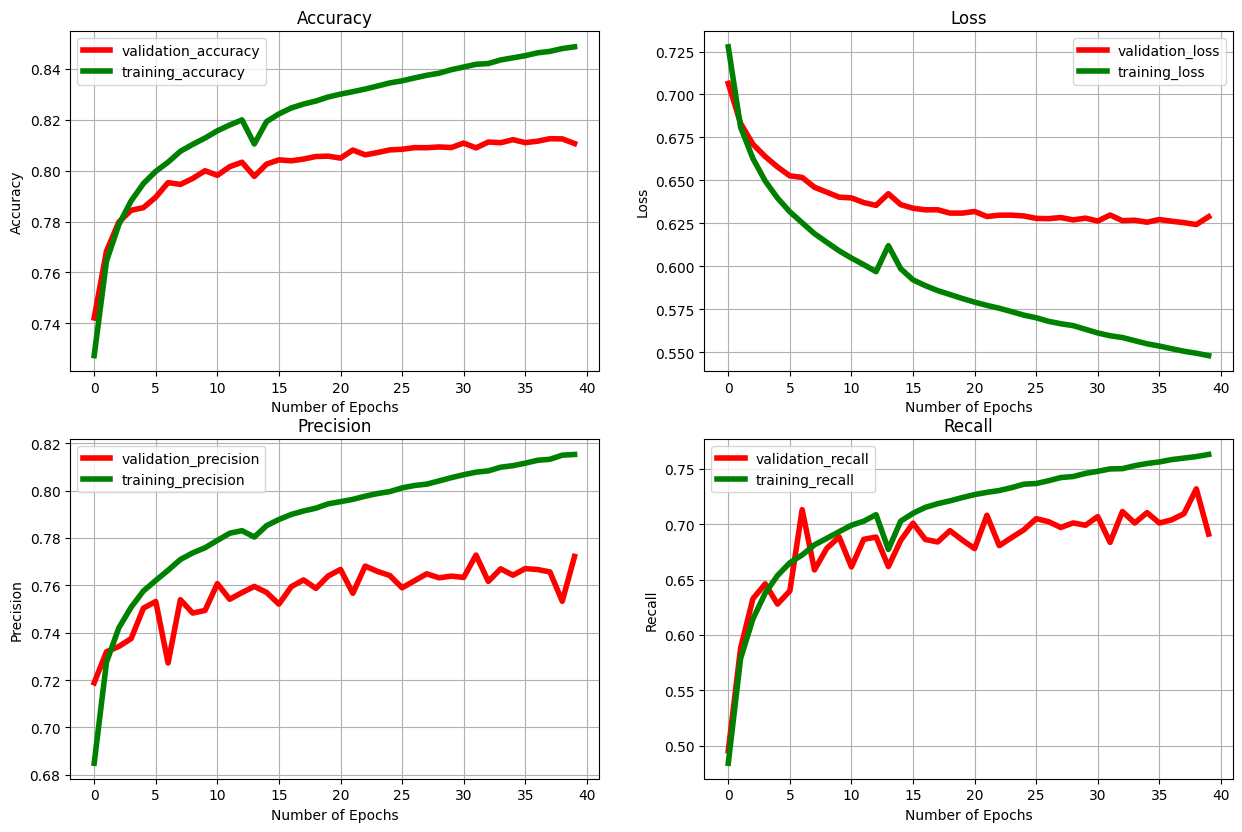

In [ ]:
### PLotting the training and validation scores across epochs. 

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(history.history["val_accuracy"], label="validation_accuracy", c="red", linewidth=4)
plt.plot(history.history["accuracy"], label="training_accuracy", c="green", linewidth=4)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(history.history["val_loss"], label="validation_loss", c="red", linewidth=4)
plt.plot(history.history["loss"], label="training_loss", c="green", linewidth=4)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)


plt.subplot(3,2,3)
plt.plot(history.history["val_precision"], label="validation_precision", c="red", linewidth=4)
plt.plot(history.history["precision"], label="training_precision", c="green", linewidth=4)
plt.xlabel("Number of Epochs")
plt.ylabel("Precision")
plt.title("Precision")
plt.legend()
plt.grid(True)


plt.subplot(3,2,4)
plt.plot(history.history["val_recall"], label="validation_recall", c="red", linewidth=4)
plt.plot(history.history["recall"], label="training_recall", c="green", linewidth=4)
plt.xlabel("Number of Epochs")
plt.ylabel("Recall")
plt.title("Recall")
plt.legend()
plt.grid(True)


plt.show()




In [ ]:
import pickle

In [ ]:
with open('quora_question_pairs_glove_tokenizer.pkl', 'wb') as fp:
        pickle.dump(tokenizer, fp)
fp.close()
#with open('quora_question_pairs_w2v_embedding_matrix.pkl', 'wb') as fp:
 #       pickle.dump(embedding_matrix, fp)
#fp.close()

In [ ]:
import pickle
with open('quora_question_pairs_glove_gru.pkl', 'wb') as fp:
        pickle.dump(siamese_model, fp)

In [ ]:
import shutil
colab_link = "/content/quora_question_pairs_glove_gru.pkl"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/quora_question_pairs_glove_gru.pkl'

In [ ]:

colab_link = "/content/quora_question_pairs_glove_tokenizer.pkl"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

# colab_link = "/content/quora_question_pairs_w2v_embedding_matrix.pkl"
# gdrive_link = "/content/drive/MyDrive/"
# shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/quora_question_pairs_glove_tokenizer.pkl'